In [104]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random


In [105]:
# Load training module
# The preproccesing code is currently quite messy, still need to clean it up
train, val, test = create_dataset('./src/pickle_df', 1)


In [106]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [107]:
# Used this method of sampling, since normal sampling will not work when channels are less than 20
def sample_5_percent(n_channels):
    count = 0
    for _ in range(n_channels):
        if random.randint(0, 19) == 0:
            count += 1
    
    return count

In [110]:
# Adds noise to a single EEG windows. Severity influences the severity of the noise
def add_noise_to_eeg(signal, severity: int):
        # Pick random method of adding noise
    random_val = random.randint(0, 2)
        # The amount of channels to add noise to is 10% multiplied by the severity
        # Thus ranging from 10% to 100%
    channels_to_corrupt = int(64 / 10 * severity)


    if random_val == 0: # Gaussian noise
            # Adds Gaussian noise to the entire length of the signal on n_channels. The sd of the noise is 0.25 multiplied by the severity
            # Thus raning from .25 to 2.5
        signal = add_gaussian_noise(signal, .25 * severity, channels_to_corrupt, 0, 308)
    elif random_val == 1: # Zeroing
            # Each channel has a 5% to be completely zeroed
        samples = sample_5_percent(channels_to_corrupt)
            # Add zero datapoints to n_channels. The percentage of datapoints to zero is 3% multiplied by the severity
            # Thus ranging from 3% to 30%
        signal = zero_signal(signal, channels_to_corrupt - samples, percentage=3 * severity)
            # If there are channels to fully zero, zero the signal with 100%
            # Note that this can be a previously partially zeroed channel, but that should not really matter
        if samples:
            signal = zero_signal(signal, samples, percentage=100)
    elif random_val == 2: # Combination of both
            # Add noise to half of the n_channels, and zero the other half
        channels_to_corrupt = int(channels_to_corrupt / 2)
        signal = add_gaussian_noise(signal, .25 * severity, channels_to_corrupt, 0, 308)
        samples = sample_5_percent(channels_to_corrupt)
        signal = zero_signal(signal, channels_to_corrupt - samples, percentage=0.03 * severity)
        if samples:
            signal = zero_signal(signal, samples, percentage=100)

    return signal


In [111]:
# Adds noise to a full training/testing/validation dataset
# Severity_index can be any value from 0 to, and including, 10.
# This index will influence the amount and severity of the noise
def add_noise_to_dataset(dataset, severity_index):
        # No noise is added when severity==0
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.05 * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        dataset[0][episode] = add_noise_to_eeg(dataset[0][episode], severity_index)

    return dataset



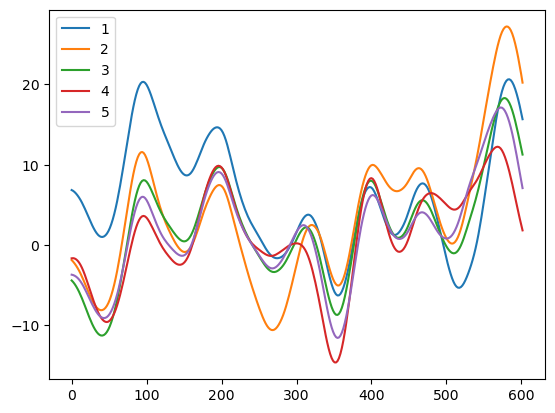

In [112]:
train_copy = copy.deepcopy(train)

duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)
plt.plot(t, train[0][0][0], label='1')
plt.plot(t, train[0][0][1], label='2')
plt.plot(t, train[0][0][2], label="3")
plt.plot(t, train[0][0][3], label="4")
plt.plot(t, train[0][0][4], label="5")
plt.legend()

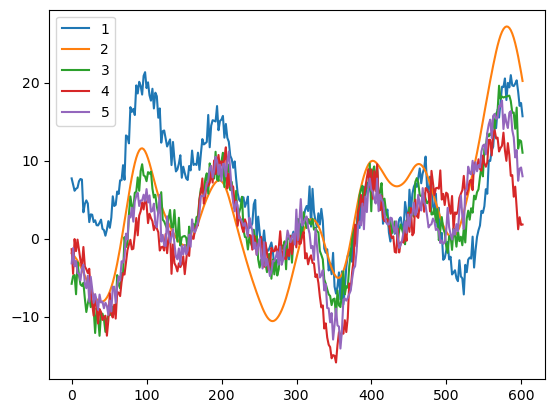

In [119]:
train_copy = copy.deepcopy(train)
corrupted = add_noise_to_eeg(train_copy[0][0], 5)
duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)
plt.plot(t, corrupted[0], label='1')
plt.plot(t, corrupted[1], label='2')
plt.plot(t, corrupted[2], label="3")
plt.plot(t, corrupted[3], label="4")
plt.plot(t, corrupted[4], label="5")
plt.legend()

In [84]:
variances = [[] for _ in range(3)]

for i in range(3):
    train_copy = copy.deepcopy(train)
    val_copy = copy.deepcopy(val)
    test_copy = copy.deepcopy(test)

    if i != 0:
        train_copy = add_noise_to_dataset(train_copy, i * 5)
        val_copy = add_noise_to_dataset(val_copy, i * 5)
        #test_copy = add_gauss_noise(test_copy, i)
        
    dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

    model = EEGNetMultiHeaded(chunk_size=308,
                            num_electrodes=64,
                            dropout=0.5,
                            kernel_1=64,
                            kernel_2=16,
                            F1=8,
                            F2=16,
                            D=2,
                            num_classes=2)

    trainer = pl.Trainer(
        max_epochs=20,
        logger=comet_logger
    )

    trainer.fit(model, datamodule=dm)
    trainer.test(model, datamodule=dm)

    valPredictSet = predictDataSet(test_copy)
    valPredictLoader = DataLoader(valPredictSet, batch_size=32, shuffle=False)
    output = trainer.predict(model=model, dataloaders=valPredictLoader)
        
    for batch in output:
        variances[i] += [i.item() for i in batch[1][0]]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd

c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottl

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8960] : (5.951758861541748, 50.148433685302734)
COMET INFO:     val_loss [1402]   : (3.081416606903076, 51.450103759765625)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     

Testing: 0it [00:00, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.21729255010966628    │
│       incorrect_var       │    0.23672011261335527    │
│         test_acc          │     0.857268750667572     │
│         test_loss         │    11.075270652770996     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.21729255010966628
COMET INFO:     incorrect_var : 0.23672011261335527
COMET INFO:     test_acc      : 0.857268750667572
COMET INFO:     test_loss     : 11.075270652770996
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages
c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_conne

Predicting: 0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti\Desktop\Bachelors project\bachelors-project\1cbab6a6a0ff4dddb49087deb0a068bd\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params 

Sanity Checking: 0it [00:00, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8960] : (9.304266929626465, 139.63873291015625)
COMET INFO:     val_loss [1402]   : (3.4649667739868164, 49.854610443115234)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 14 metrics, params and output messages


Testing: 0it [00:00, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.23584034539177726    │
│       incorrect_var       │    0.24565215652424194    │
│         test_acc          │    0.8792951703071594     │
│         test_loss         │    12.029556274414062     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.23584034539177726
COMET INFO:     incorrect_var : 0.24565215652424194
COMET INFO:     test_acc      : 0.8792951703071594
COMET INFO:     test_loss     : 12.029556274414062
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages


Predicting: 0it [00:00, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [8960] : (11.05014419555664, 13830.25)
COMET INFO:     val_loss [1402]   : (5.456058979034424, 52.817787170410156)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


Testing: 0it [00:00, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.24820119329210197    │
│       incorrect_var       │    0.24837027932171724    │
│         test_acc          │    0.2541850209236145     │
│         test_loss         │     18.00054931640625     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/1cbab6a6a0ff4dddb49087deb0a068bd
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.24820119329210197
COMET INFO:     incorrect_var : 0.24837027932171724
COMET INFO:     test_acc      : 0.2541850209236145
COMET INFO:     test_loss     : 18.00054931640625
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 20 metrics, params and output messages


Predicting: 0it [00:00, ?it/s]

In [13]:
np.array(variances[0]).mean()

0.2398894171823155